In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [2]:
df = pd.read_csv('prepared_data_book.csv')
df.head(5)

,Unnamed: 0,product_id,title,authors,original_price,current_price,quantity,category,n_review,avg_rating,pages,manufacturer,cover_link,discount
0,0,74021317,Cây Cam Ngọt Của Tôi,José Mauro de Vasconcelos,4.56,2.73,53075,Tiểu Thuyết,11481,5.0,244,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/5e/18/24/2...,0.4
1,2,184466860,Hành Tinh Của Một Kẻ Nghĩ Nhiều,Nguyễn Đoàn Minh Thư,3.63,2.53,7929,Others,780,4.8,184,Nhà Xuất Bản Thế Giới,https://salt.tikicdn.com/ts/product/d7/99/24/1...,0.3
2,3,73787185,Những Tù Nhân Của Địa Lý,Tim Marshall,8.86,5.32,17896,Lĩnh vực khác,3623,4.8,430,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/8d/96/9e/c...,0.4
3,4,52789367,Nhà Giả Kim (Tái Bản 2020),Paulo Coelho,3.33,2.00,24668,Tác phẩm kinh điển,5131,5.0,228,Nhà Xuất Bản Hà Nội,https://salt.tikicdn.com/ts/product/45/3b/fc/a...,0.4
4,5,147920903,Một Thoáng Ta Rực Rỡ Ở Nhân Gian,Unknown,5.70,3.42,10000,Tiểu Thuyết,1636,4.8,304,Nhà Xuất Bản Hội Nhà Văn,https://salt.tikicdn.com/ts/product/2f/b5/4e/a...,0.4


Điền thiếu

In [4]:
df['discount'].fillna(0, inplace=True)

Thống kê mô tả của các trường dữ liệu số

In [5]:
num_cols = ['original_price', 'current_price', 'quantity', 'n_review', 'avg_rating', 'pages', 'discount']
df[num_cols].describe()

,original_price,current_price,quantity,n_review,avg_rating,pages,discount
count,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000,1766.000000
mean,6.692361,4.861433,2427.056059,327.984711,4.596263,347.201019,0.272225
std,5.368553,4.299462,5391.804820,730.251069,1.130067,180.604684,0.135348
min,0.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000
25%,3.760000,2.530000,180.250000,16.000000,4.800000,220.000000,0.200000
50%,5.440000,3.750000,608.000000,75.000000,4.800000,332.000000,0.300000
75%,7.970000,5.760000,2371.500000,303.000000,5.000000,456.000000,0.370000
max,65.400000,50.630000,65623.000000,11481.000000,5.000000,2004.000000,0.800000


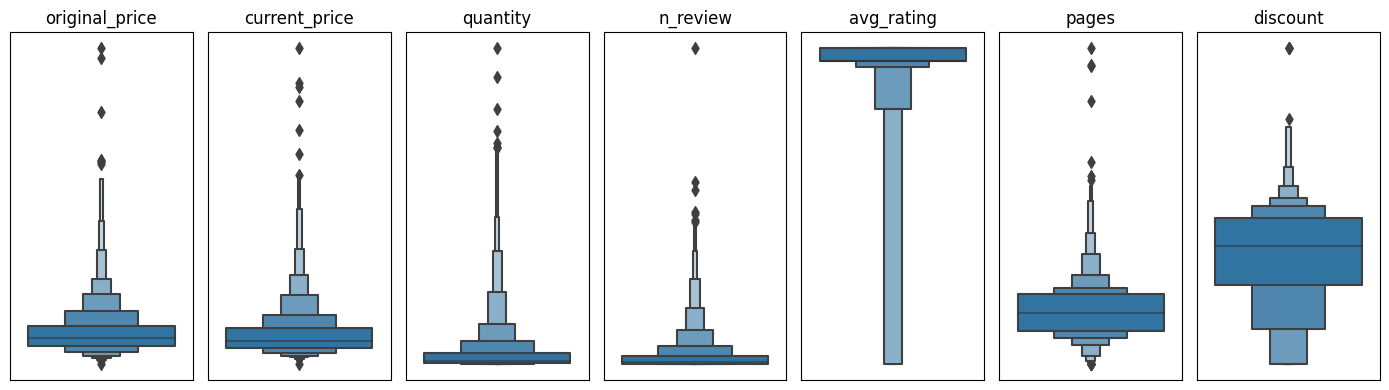

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(14, 4))

for i, col in enumerate(num_cols):
    sns.boxenplot(data=df[col], ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel('')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

Thay thế giá trị lỗi

# Trực quan hóa

## Top 10 tác giả dựa trên số lượng bán

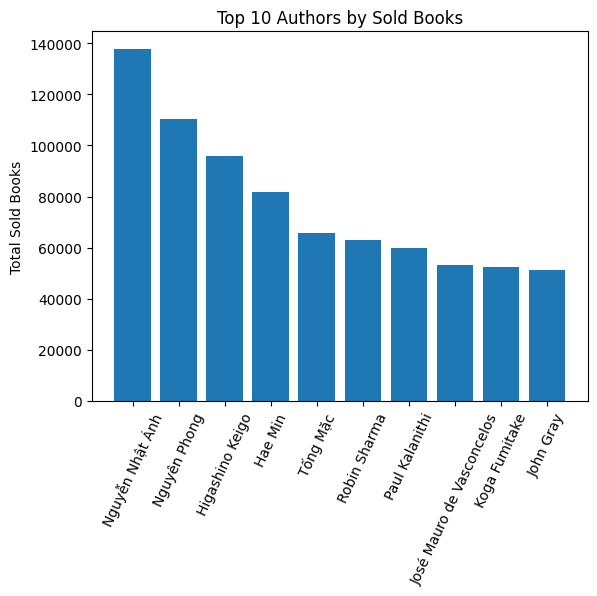

In [7]:
df = df[df['authors'] != 'Unknown']
author_sales = df.groupby('authors')['quantity'].sum().nlargest(10)

# Create a bar chart of the top 10 authors by sold books
plt.bar(author_sales.index, author_sales.values)
plt.title('Top 10 Authors by Sold Books')
plt.ylabel('Total Sold Books')

# Rotate the x-axis tick labels by 65 degrees
plt.xticks(rotation=65)

plt.show()

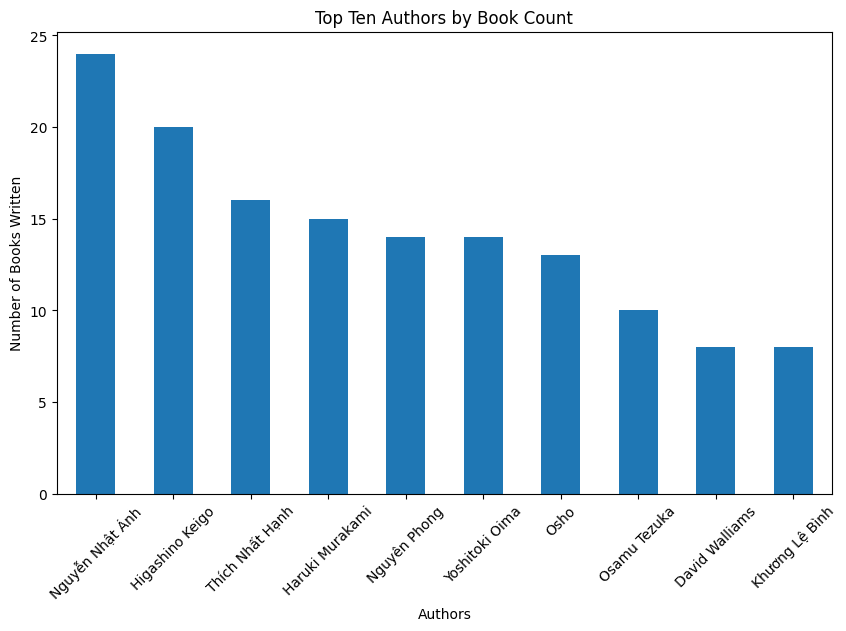

In [8]:
# Calculate the count of books written by each author
books_written = df.groupby('authors')['product_id'].count()

# Select the top ten authors by book count
top_authors = books_written[books_written.index != "Nhiều tác giả"].nlargest(10)

# Create a bar plot to visualize the top ten authors by book count
plt.figure(figsize=(10, 6))
top_authors.plot(kind='bar')
plt.xlabel('Authors')
plt.ylabel('Number of Books Written')
plt.title('Top Ten Authors by Book Count')
plt.xticks(rotation=45)
plt.show()

Quan sát biểu đồ trên, ta có thể thấy tác giả viết càng nhiều sách thì có xu hướng bán được nhiều sách hơn. Để kiểm chứng điều này, chúng ta cần tiến hành kiểm định các giả thuyết sau:

\begin{cases}
H_0: \text{``Viết càng nhiều sách thì bán càng nhiều"} \\
H_1: \text{``Viết nhiều sách thì chưa chắc bán càng nhiều"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [9]:
from scipy import stats

books_written = df.groupby('authors')['product_id'].count()
top_authors = books_written[books_written.index != "Nhiều tác giả"]



df = df[df['authors'] != 'Unknown']
author_sales = df.groupby('authors')['quantity'].sum()


t_statistic, p_value = stats.ttest_ind(top_authors, author_sales, alternative='less')

print("t-statistic = ", t_statistic)
print("p-value = ", p_value)

alpha = 0.05

if p_value <= alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic =  -13.003888700324213
p-value =  1.4056369262872555e-37
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


## Càng nhiều review càng bán được nhiều sách

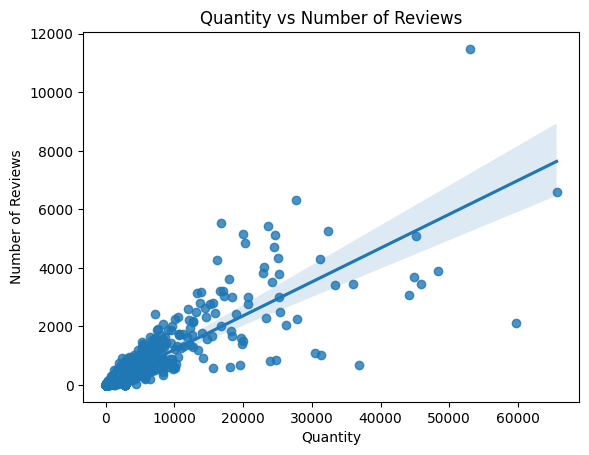

In [10]:
quantity = df['quantity']
n_reviews = df['n_review']

sns.regplot(x=quantity, y=n_reviews)
plt.xlabel('Quantity')
plt.ylabel('Number of Reviews')
plt.title('Quantity vs Number of Reviews')
plt.show()


Quan sát biểu đồ trên, ta có thể thấy sách có nhiều review có xu hướng bán được nhiều hơn. Để kiểm chứng điều này, chúng ta cần tiến hành kiểm định các giả thuyết sau:

\begin{cases}
H_0: \text{``Càng nhiều review càng bán được nhiều sách"} \\
H_1: \text{``Nhiều review thì chưa chắc bán được nhiều sách"}
\end{cases}

Với mức ý nghĩa $\alpha$:

- Nếu $p-\text{value} \le \alpha$ thì bác bỏ giả thuyết $H_0$, chấp nhận $H_1$ với độ tin cậy $100(1 − \alpha)\%$.

- Nếu $p-\text{value} > \alpha$, chưa đủ cơ sở bác bỏ giả thuyết $H_0$ với mức ý nghĩa $\alpha$.

In [11]:
from scipy import stats

n_reviews = df['n_review']
quantity = df['quantity']

t_statistic, p_value = stats.ttest_ind(n_reviews, quantity, alternative='less')

print("t-statistic =", t_statistic)
print("p-value =", p_value)

alpha = 0.05
if p_value < alpha:
    print(f"Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy {100*(1 - alpha)}%")
else:
    print(f"Chưa đủ cơ sở bác bỏ giả thuyết H_0 với mức ý nghĩa {alpha}")

t-statistic = -15.463543980945879
p-value = 2.1851164311898368e-52
Bác bỏ giả thuyết H_0, chấp nhận H_1 với độ tin cậy 95.0%


## Tìm hiểu nhu cầu thị trường ( phân tích xem thể loại sách, giá bán,... và số lượng sách bán ra) từ đó đề xuất đề xuất cho tiki nên phát triển loại sách nào


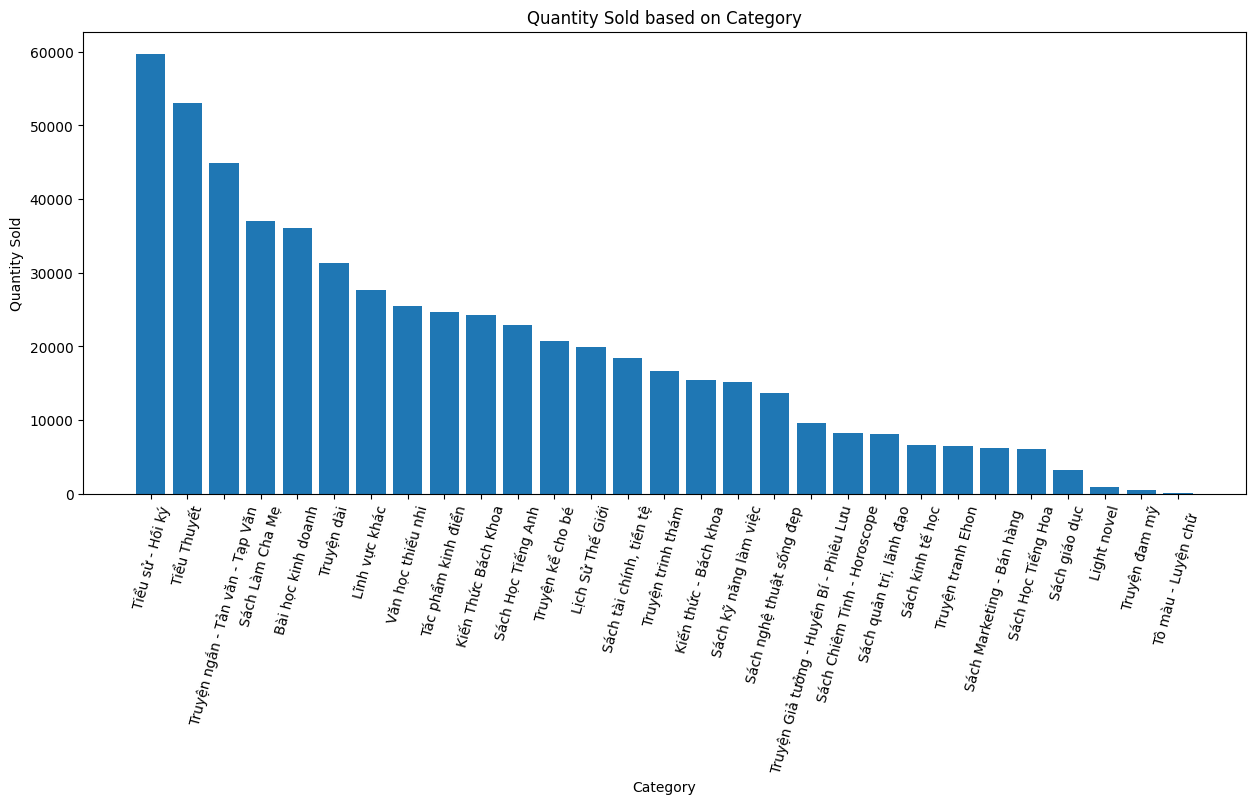

In [32]:
filtered_df = df[df['category'] != 'Others']

# Sort the filtered dataframe by quantity sold in descending order
sorted_df = filtered_df.sort_values('quantity', ascending=False)

# Create a bar chart without the "Others" category
plt.figure(figsize=(15, 6))
plt.bar(sorted_df['category'], sorted_df['quantity'])
plt.xlabel("Category")
plt.ylabel("Quantity Sold")
plt.title("Quantity Sold based on Category")
plt.xticks(rotation=75)
plt.show()

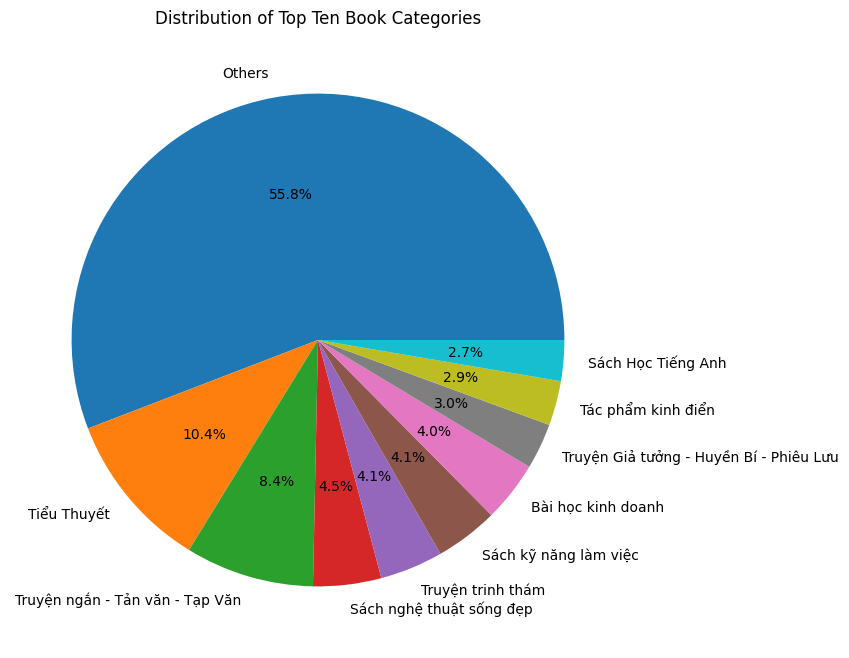

In [44]:
# Calculate the distribution of book categories
category_counts = df['category'].value_counts()

# Select the top ten categories
top_categories = category_counts[:10]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_categories, labels=top_categories.index, autopct="%1.1f%%")
plt.title("Distribution of Top Ten Book Categories")
plt.show()